<a href="https://colab.research.google.com/github/inhopp/ML_code/blob/main/style_transfer_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import PIL  # python image library
import matplotlib.pyplot as plt
import copy

In [7]:
# GPU 장치 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# image to tensor
def image_loader(img_path, imsize):
  loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor() # tensor 형식으로 변경 [0,255] -> [0,1]
  ])
  image = PIL.Image.open(img_path)
  # 네트워크 입력에 들어갈 이미지에 배치 목적의 차원 추가
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float) # GPU에 올리기


# tensor to image
def imshow(tensor):
 # matplotlib은 CPU 기반이므로 다시 CPU로 옮기기
 image = tensor.cpu().clone()
 # torch.tensor에서 사용되는 배치 목적의 차원 제거
 image = image.squeeze(0)
 
 image = transforms.ToPILImage()(image)
 plt.imshow(image)
 plt.show()

In [5]:
# 저장소의 소스코드를 다운로드하여 실습용 이미지 준비하기
!git clone https://github.com/inhopp/ML_code
%cd ML_code

Cloning into 'ML_code'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.
/content/ML_code


# Image Reconstruction

In [ ]:
#image 불러오기
img_path = './cat.jpg'
target_image = image_loader(img_path, (512,512))
imshow(target_image)

In [ ]:
# 동일한 크기의 노이즈 이미지 만들기
noise = torch.empty_like(target_image).uniform_(0, 1).to(device)
imshow(noise)

In [ ]:
loss = nn.MSELoss() # Loss function 설정
iters = 100 # 반복(iteration) 횟수 설정
lr = 1e4 # learning rate 설정

print("[ Start ]")
imshow(noise)

for i in range(iters):
  noise.requires_grad = True # 연산 추적 (기록)

  output = loss(noise, target_image)
  output.backward()
  gradient = lr* noise.grad

  # 각 픽셀의 값이 [min, max] 사이의 값이 되도록 clamping (넘어가면 자르기)
  # 연산 추적을 중단하기 위해 detach()
  noise = torch.clamp(noise - gradient, min=0, max=1).detach_()

  if (i+1) % 10 == 0:
    print(f'[ Step: {i+1} ]')
    print(f'Loss: {output}')
    imshow(noise)

# Style transfer

[ Content Image ]


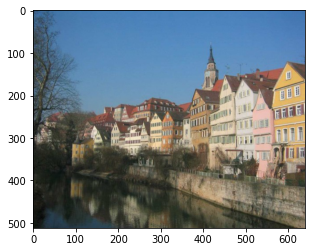

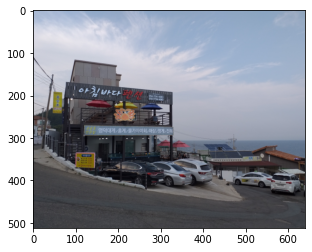

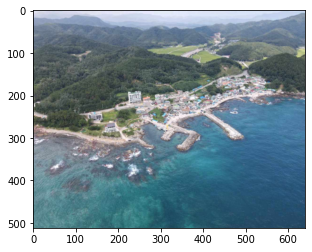

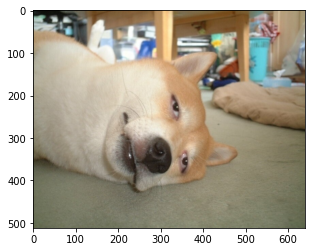

[ Style Image ]


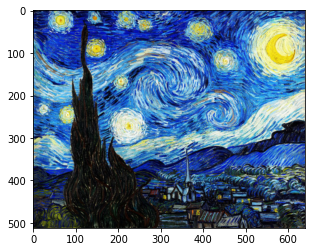

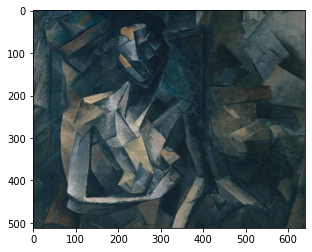

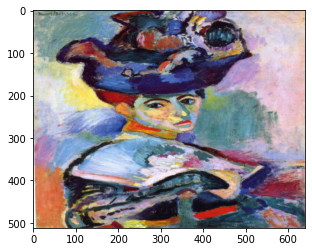

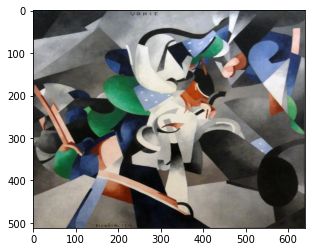

In [9]:
content_img1 = image_loader('./content_img_1.jpg', (512, 640))
content_img2 = image_loader('./content_img_2.jpg', (512, 640))
content_img3 = image_loader('./content_img_3.jpg', (512, 640))
content_img4 = image_loader('./content_img_4.jpg', (512, 640))
style_img1 = image_loader('./style_img_1.jpg', (512, 640))
style_img2 = image_loader('./style_img_2.jpg', (512, 640))
style_img3 = image_loader('./style_img_3.jpg', (512, 640))
style_img4 = image_loader('./style23.jpg', (512, 640))

print("[ Content Image ]")
imshow(content_img1)
imshow(content_img2)
imshow(content_img3)
imshow(content_img4)
print("[ Style Image ]")
imshow(style_img1)
imshow(style_img2)
imshow(style_img3)
imshow(style_img4)

# CNN Network - VGG19 불러오기

In [16]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
print(cnn)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [17]:
# VGG 네트워크는 평균 = [0.485, 0.456, 0.406] 및 표준편차 = [0.229, 0.224, 0.225]로 정규화 된 각 채널의 이미지에 대해 학습된 모델입니다. 
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = mean.clone().view(-1, 1, 1)
    self.std = std.clone().view(-1, 1, 1)

  def forward(self, img):
    return (img - self.mean) / self.std

# Style Reconstruction

In [18]:
def gram_matrix(input):
  # a: 배치 크기, b: 필터 개수, c,d: 필터 차원
  a, b, c, d = input.size()
  features = input.view(a*b, c*d)
  G = torch.mm(features, features.t())
  # div() : Nomalize
  return G.div(a*b*c*d)

class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

In [19]:
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_losses(cnn, style_img, noise_image):
  cnn = copy.deepcopy(cnn)
  normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
  style_losses = []

  # image 들어오면 input normalization 먼저 수행
  model = nn.Sequential(normalization)

  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    # 설정한 style layer까지 loss 계산
    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)

  # 마지막 style loss layer는 사용하지 않음
  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], StyleLoss):
      break

  model = model[:(i + 1)]
  return model, style_losses

In [20]:
def style_reconstruction(cnn, style_img, input_img, iters):
  model, style_losses = get_style_losses(cnn, style_img, input_img)
  optimizer = optim.LBFGS([input_img.requires_grad_()])

  print("[ Start ]")
  imshow(input_img)

  # 하나의 값만 이용하기 위해 배열 형태로 사용 ..??
  run = [0]
  while run[0] <= iters:
    def closure():
      input_img.data.clamp_(0, 1)

      optimizer.zero_grad()
      model(input_img)
      style_score = 0

      for sl in style_losses:
        style_score += sl.loss

      style_score *= 1e6
      style_score.backward()

      run[0] += 1
      if run[0] % 50 == 0:
        print(f"[ Step: {run[0]} / Style loss: {style_score.item()}")
        imshow(input_img)

      return style_score

    optimizer.step(closure)

  input_img.data.clamp_(0, 1)

  return input_img

In [ ]:
# content image와 동일한 크기의 노이즈 이미지 준비
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

In [ ]:
# style reconstuction
output = style_reconstruction(cnn, style_img=style_img, input_img=input_img, iters=300)

# Content Reconstruction

In [26]:
class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

In [27]:
content_layers = ['conv_4']

def get_content_losses(cnn, content_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 content layer까지의 결과를 이용해 content loss를 계산
        if name in content_layers:
            target_feature = model(content_img).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

    # 마지막 content loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss):
            break

    model = model[:(i + 1)]
    return model, content_losses

In [ ]:
def content_reconstruction(cnn, content_img, input_img, iters):
    model, content_losses = get_content_losses(cnn, content_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0

            for cl in content_losses:
                content_score += cl.loss

            content_score.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()}]")
                imshow(input_img)
            
            return content_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

In [ ]:
# content reconstruction 수행
output = content_reconstruction(cnn, content_img=content_img, input_img=input_img, iters=300)

# Style Transfer

In [21]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_7', 'conv_9']

# Style Transfer 손실(loss)을 계산하는 함수
def get_losses(cnn, content_img, style_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    style_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 content layer까지의 결과를 이용해 content loss를 계산
        if name in content_layers:
            target_feature = model(content_img).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 마지막 loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, content_losses, style_losses

In [35]:
def style_transfer(cnn, content_img, style_img, input_img, iters):
    model, content_losses, style_losses = get_losses(cnn, content_img, style_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0
            style_score = 0

            for cl in content_losses:
                content_score += cl.loss
            for sl in style_losses:
                style_score += sl.loss

            style_score *= 1e4
            loss = content_score + style_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return content_score + style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

[ Content Image ]


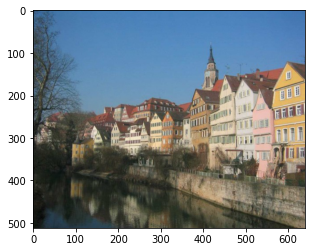

[ Style Image ]


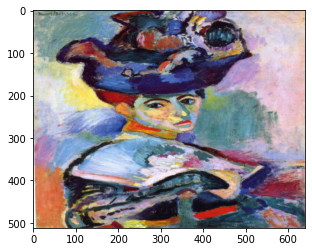

In [23]:
# 콘텐츠(Content) 이미지와 스타일(Style) 이미지를 모두 준비합니다.
content_img = image_loader('./content_img_1.jpg', (512, 640))
style_img = image_loader('./style_img_3.jpg', (512, 640))

print("[ Content Image ]")
imshow(content_img)
print("[ Style Image ]")
imshow(style_img)

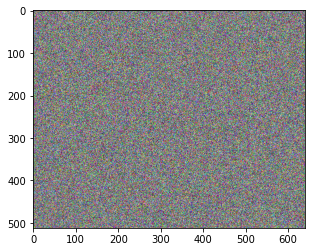

In [24]:
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

In [37]:
# style transfer 수행
output = style_transfer(cnn, content_img=content_img, style_img=style_img, input_img=input_img, iters=700)

KeyboardInterrupt: ignored

In [ ]:
from torchvision.utils import save_image
from google.colab import files

save_image(output.cpu().detach()[0], 'output_1.png')
print('이미지 파일 저장을 완료했습니다.')

# 완성된 이미지를 다운로드합니다.
files.download('output_1.png')

In [ ]:
from IPython.display import Image

Image('output_1.png')